# Sonic Porosity Log: Predicting DTS and DTC 
## Using Wavelet Transforms and ML 
Sonic Log also called porosity logs are sets of data collected and used by geophyicists to evalute the rock layer properties of well bores.  Sound waves are generated transverse/ compressiona and shearwave in the bore hole or adjecent too and the returning sound is collected.  The delta T ( of time of fight) and wave type can reveal information about the resevoir and rock layers.  This information is vital to maximize the cost and efficiency and production in the oil and gas industry drilling operations.   This project will attempt to show that the shearwave DTS and compressional wave DTC  data which is often missing parts or not collected, yet very vital, can be predicted given other features in the logs. 

### Wavelet transform and XGBoost Regression used for predictions

## Data is taken from Synthethic Sonic Log Curves Generation Contest 

#### Description fo the data:
- CAL - Caliper, unit in Inch,
- CNC - Neutron, unit in dec
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter,
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

import xgboost as xgb

In [4]:
# Load in the train and test data sets from GitHub 
urltr = 'https://raw.githubusercontent.com/LadyKate7390/Kate_G_DS_Portfolio/refs/heads/main/Sonic%20Wave%20Velocity/train.csv'
urltest = 'https://raw.githubusercontent.com/LadyKate7390/Kate_G_DS_Portfolio/refs/heads/main/Sonic%20Wave%20Velocity/test.csv'
url = 'https://raw.githubusercontent.com/LadyKate7390/Kate_G_DS_Portfolio/refs/heads/main/Sonic%20Wave%20Velocity/real_test_result.csv'
tr_df = pd.read_csv(urltr)
ts_df= pd.read_csv(urltest)

In [5]:
print(tr_df.shape,ts_df.shape)

(30143, 9) (11088, 7)


In [6]:
tr_df.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


In [7]:
# make a copy of train set as we clean up some data
dft = tr_df.copy()

In [8]:
# replace negative -999 values and deal with missing data (Na) 
dft.replace(['-999', -999], np.nan, inplace=True)

In [9]:
nan_counts = dft.isnull().sum()
print(nan_counts)

CAL      510
CNC      735
GR       254
HRD      385
HRM      385
PE       679
ZDEN     681
DTC     4054
DTS     4865
dtype: int64


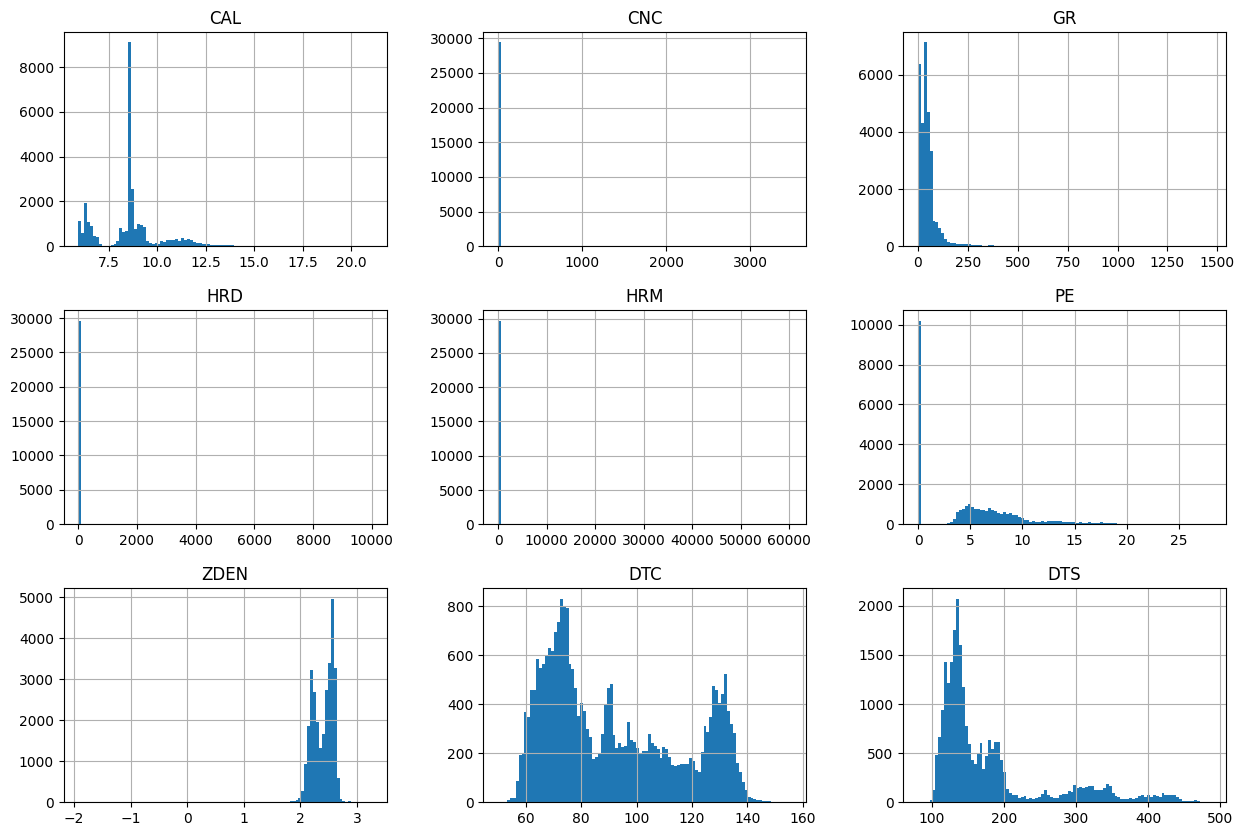

In [10]:
histdf = dft.hist(bins=100,figsize=(15,10))

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

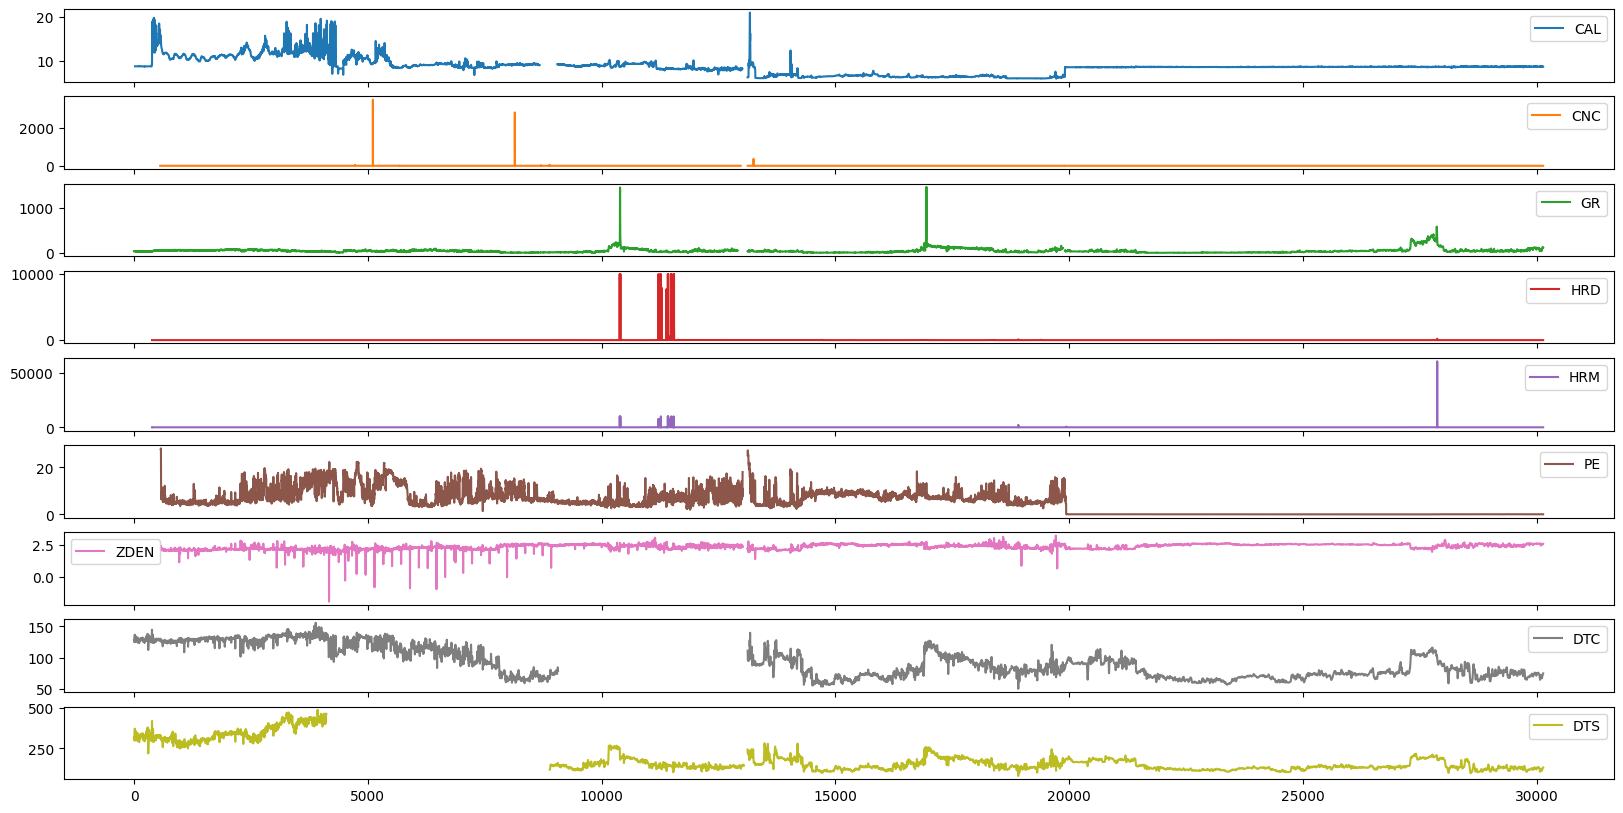

In [11]:
dft.plot(subplots=True,figsize=(20,10))

In [12]:
#Making negative values Nan of ZDEN, GR, CNC, PE. We don't want to just drop them or make them '0' for now
col = ['ZDEN', 'GR', 'CNC', 'PE']
dft[col] = dft[col].mask(dft[col] < 0)



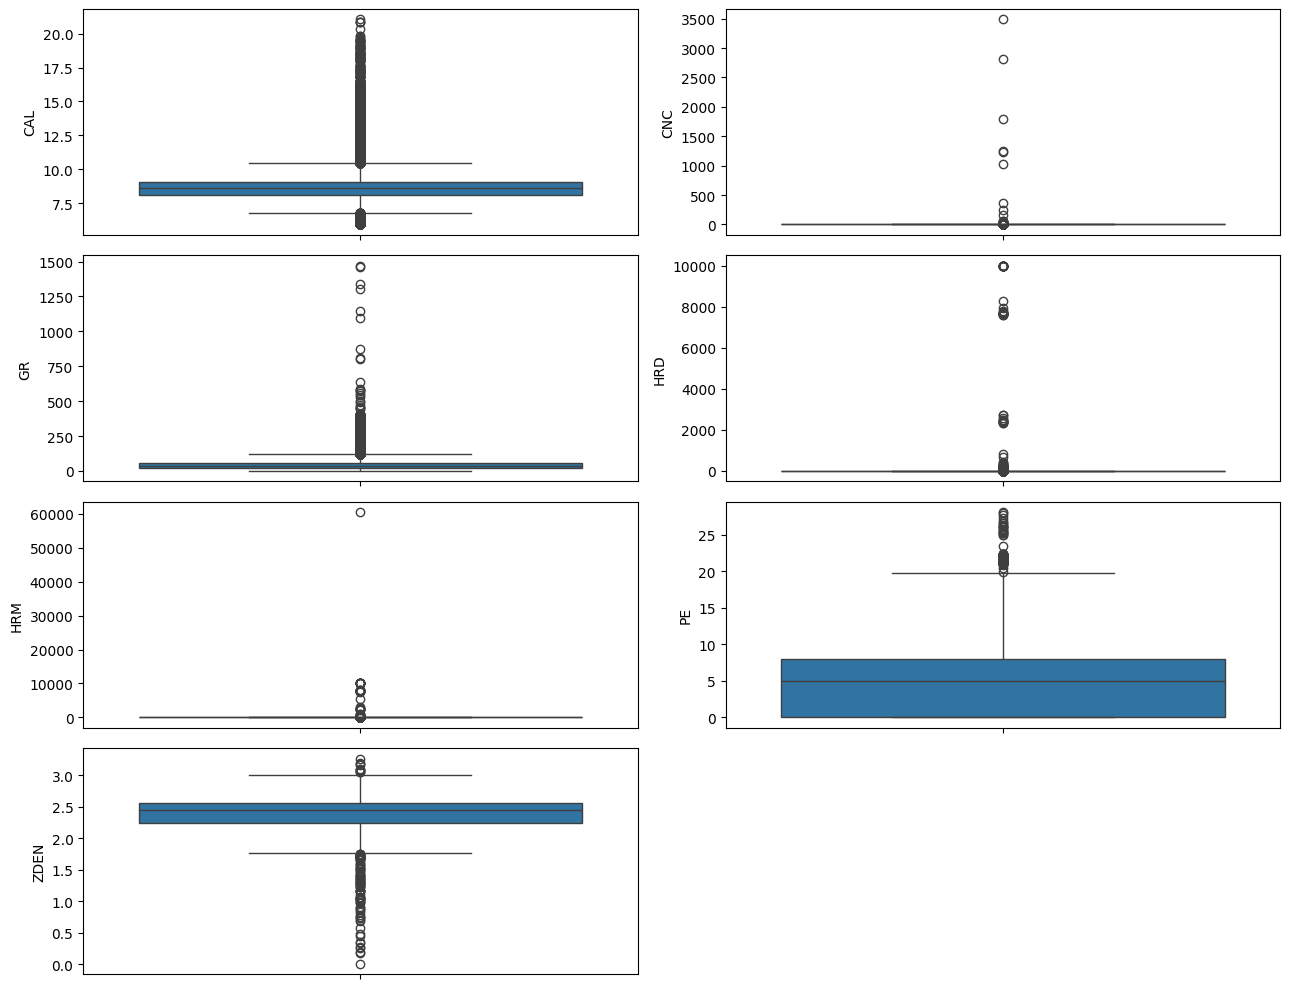

In [13]:
plt.figure(figsize=(13,10))
plt.subplot(4,2,1)
sns.boxplot(dft['CAL'])

plt.subplot(4,2,2)
sns.boxplot(dft['CNC'])

plt.subplot(4,2,3)
sns.boxplot(dft['GR'])

plt.subplot(4,2,4)
sns.boxplot(dft['HRD'])

plt.subplot(4,2,5)
sns.boxplot(dft['HRM'])

plt.subplot(4,2,6)
sns.boxplot(dft['PE'])

plt.subplot(4,2,7)
sns.boxplot(dft['ZDEN'])

plt.tight_layout()
plt.show()

In [14]:
# transforming a few variables with log function and replotting 
dft['HRM'] = dft['HRM'].apply(lambda x:np.log(x))
dft['HRD'] = dft['HRD'].apply(lambda x:np.log(x))


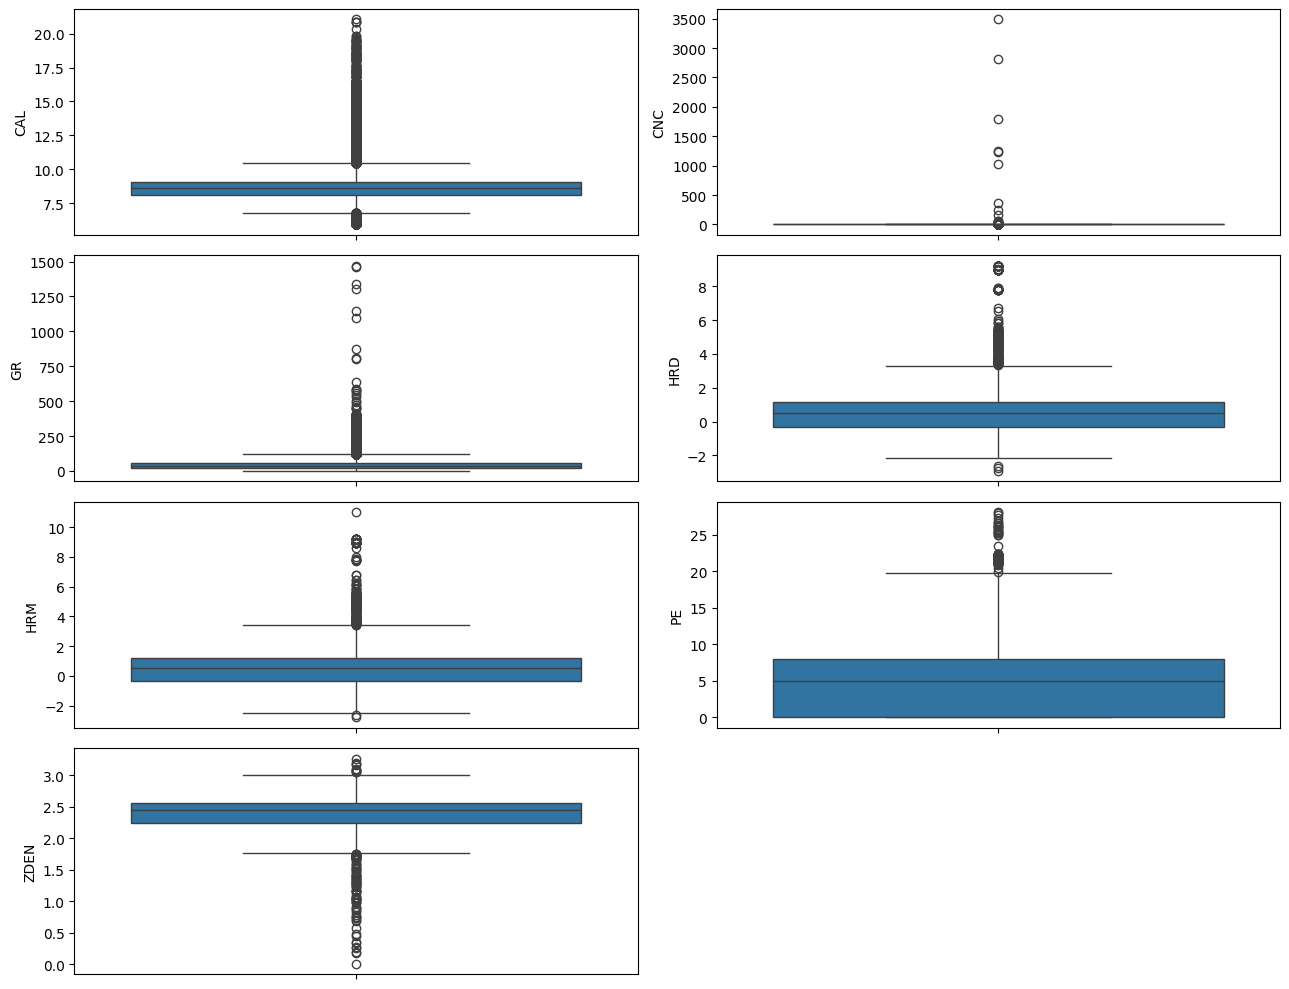

In [15]:
plt.figure(figsize=(13,10))
plt.subplot(4,2,1)
sns.boxplot(dft['CAL'])

plt.subplot(4,2,2)
sns.boxplot(dft['CNC'])

plt.subplot(4,2,3)
sns.boxplot(dft['GR'])

plt.subplot(4,2,4)
sns.boxplot(dft['HRD'])

plt.subplot(4,2,5)
sns.boxplot(dft['HRM'])

plt.subplot(4,2,6)
sns.boxplot(dft['PE'])

plt.subplot(4,2,7)
sns.boxplot(dft['ZDEN'])

plt.tight_layout()
plt.show()

In [16]:
#Looking for correlations 
dft.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
CAL,1.000000,0.008630,0.020420,-0.189213,-0.158098,0.163877,-0.368183,0.585637,0.681271
CNC,0.008630,1.000000,-0.003245,-0.007311,-0.007969,0.017053,-0.008496,0.008642,0.048946
GR,0.020420,-0.003245,1.000000,-0.021496,-0.019504,-0.034032,-0.158940,0.355556,0.233183
HRD,-0.189213,-0.007311,-0.021496,1.000000,0.972225,-0.223456,0.570952,-0.608361,-0.407105
HRM,-0.158098,-0.007969,-0.019504,0.972225,1.000000,-0.260325,0.576939,-0.602069,-0.411537
PE,0.163877,0.017053,-0.034032,-0.223456,-0.260325,1.000000,-0.340607,0.477524,0.440266
ZDEN,-0.368183,-0.008496,-0.158940,0.570952,0.576939,-0.340607,1.000000,-0.756792,-0.670186
DTC,0.585637,0.008642,0.355556,-0.608361,-0.602069,0.477524,-0.756792,1.000000,0.941639
DTS,0.681271,0.048946,0.233183,-0.407105,-0.411537,0.440266,-0.670186,0.941639,1.000000


In [17]:
ts_df.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
CAL,1.000000,-0.290943,0.024399,0.037764,0.050929,0.446757,0.438947
CNC,-0.290943,1.000000,0.575440,-0.247362,0.016520,-0.563464,-0.710657
GR,0.024399,0.575440,1.000000,-0.124756,0.154772,-0.121305,-0.129897
HRD,0.037764,-0.247362,-0.124756,1.000000,0.415450,-0.002108,0.077118
HRM,0.050929,0.016520,0.154772,0.415450,1.000000,0.046397,0.028714
PE,0.446757,-0.563464,-0.121305,-0.002108,0.046397,1.000000,0.870180
ZDEN,0.438947,-0.710657,-0.129897,0.077118,0.028714,0.870180,1.000000


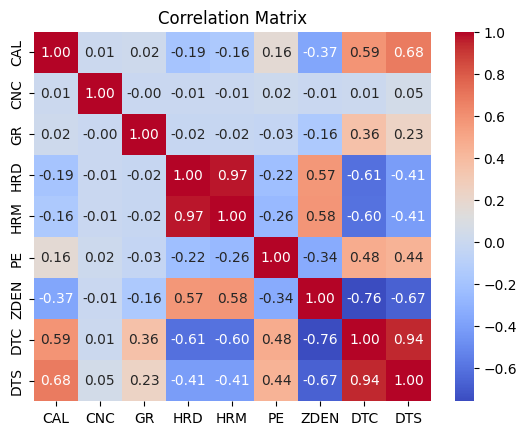

In [18]:
# Correlation Matrix 
corr_matrix = dft.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

The intent was to use ppscore but issues with instalation with the library has led to using an alrenative MIC as the pearson method above is best suited for linear relationships which this data is not. 


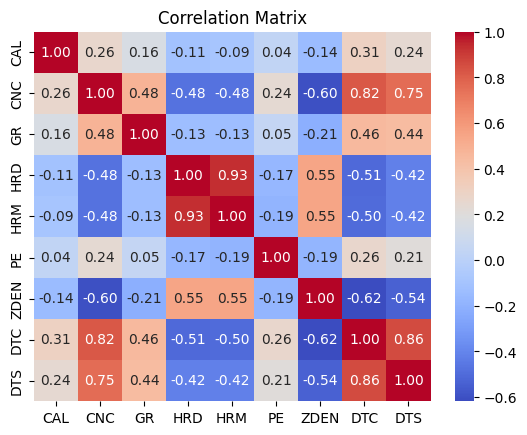

In [19]:
corr_matrix = dft.corr(method='kendall')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Running two differnt correlations using two different scoring types one for more linear relationships 
the other not.  Some slight differences in scoring is note. The Kendall method gave some stronger correlations between some features suggesting that there are strong non-linear relationships exist. 

# Building the Models 

In [20]:
# Create separate datasets for DTC and DTS
df_dtc = dft.dropna(subset=['DTC'])
df_dts = dft.dropna(subset=['DTS'])

In [21]:
df_dtc= df_dtc.dropna()
df_dts= df_dts.dropna()

In [22]:
#X
df_dtc_x = df_dtc.drop(columns=['DTC','DTS'])
df_dts_x = df_dts.drop(columns=['DTC','DTS'])

In [23]:
#Y
y_dtc = df_dtc['DTC']
y_dts = df_dts['DTS']

In [24]:
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(df_dtc_x,y_dtc, test_size=0.30, random_state=42, shuffle = True)

In [25]:
X_train_dts, X_test_dts, y_train_dts, y_test_dts = train_test_split(df_dts_x,y_dts, test_size=0.30, random_state=42, shuffle = True)

#  Hyper parameters used in X G Boost 
## Training dataframe for DTS,DTC

# DTC

In [26]:
xgb_model_dtc = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)

In [27]:
xgb_model_dtc.fit(X_train_dtc, y_train_dtc)
y_pred_test_dtc = xgb_model_dtc.predict(X_test_dtc)
y_pred_train_dtc = xgb_model_dtc.predict(X_train_dtc)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dtc,y_pred_train_dtc))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dtc,y_pred_test_dtc))))
print("R2_train:     " + str(r2_score(y_train_dtc,y_pred_train_dtc)))
print("R2_test:     " + str(r2_score(y_test_dtc,y_pred_test_dtc)))

RMSE_train:     3.6395132541518165
RMSE_test:     3.8130813044465572
R2_train:     0.9761344369583579
R2_test:     0.9736840357693544


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

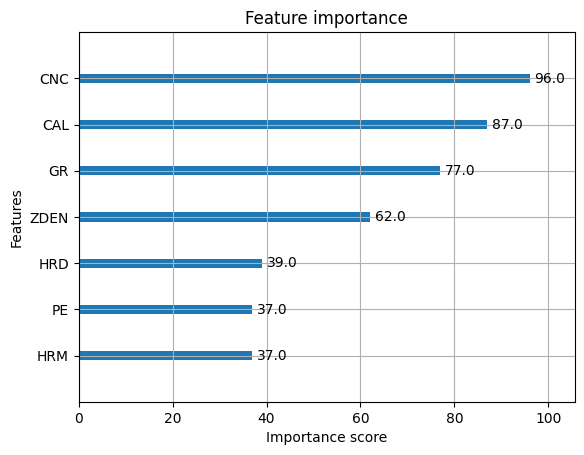

In [28]:
xgb.plot_importance(xgb_model_dtc)

# DTS

In [29]:
xgb_model_dts = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)

In [30]:
xgb_model_dts.fit(X_train_dts, y_train_dts)
y_pred_test_dts = xgb_model_dts.predict(X_test_dts)
y_pred_train_dts = xgb_model_dts.predict(X_train_dts)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dts,y_pred_train_dts))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dts,y_pred_test_dts))))
print("R2_train:     " + str(r2_score(y_train_dts,y_pred_train_dts)))
print("R2_test:     " + str(r2_score(y_test_dts,y_pred_test_dts)))

RMSE_train:     4.464013144518742
RMSE_test:     8.283328798602609
R2_train:     0.9972059822809354
R2_test:     0.9905539483810054


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

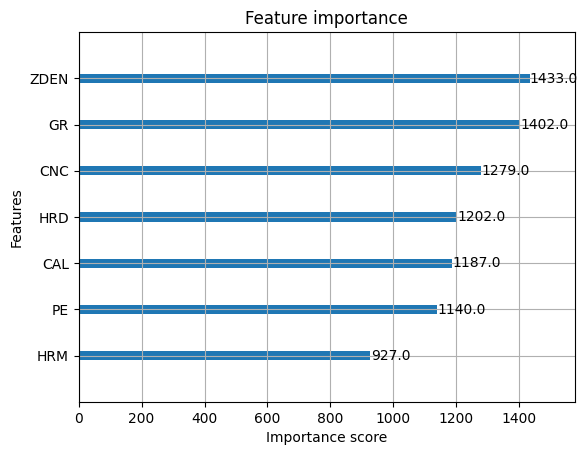

In [31]:
xgb.plot_importance(xgb_model_dts)

# Test Data 
     Running predictions using the test data set

In [32]:
# Preparing the test dataframe 
# Replace value -999 ( missing value indicators ) as NA
ts_df.replace(['-999', -999], np.nan, inplace=True)
# Nullify the Negative Values
col = ['ZDEN', 'GR', 'CNC', 'PE']
ts_df[col] = ts_df [col].mask(dft[col] < 0)

# Nullify the Outliers
ts_df['CNC'][ts_df['CNC']>0.7] = np.nan
ts_df['GR'][(ts_df['GR']>250)] = np.nan
ts_df['HRD'][ts_df['HRD']>200] = np.nan
ts_df['HRM'][ts_df['HRM']>200] = np.nan

        
# Log Transformation
ts_df['HRD'] = np.log(ts_df['HRD'])
ts_df['HRM'] = np.log(ts_df['HRM'])

/var/folders/lw/vmbvrc855dqff2_jwv62tbs40000gn/T/ipykernel_53970/225633186.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ts_df['CNC'][ts_df['CNC']>0.7] = np.nan
/var/folders/lw/vmbvrc855dqff2_jwv62tbs40000gn/T/ipykernel_53970/225633186

In [33]:
ts_df.isnull().sum()

CAL      0
CNC      0
GR      33
HRD      1
HRM     27
PE       0
ZDEN     0
dtype: int64

In [34]:
ts_df['GR']= ts_df['GR'].fillna(ts_df['GR'].mean())
ts_df['HRD']= ts_df['HRD'].fillna(ts_df['HRD'].mean())
ts_df['HRM']= ts_df['HRM'].fillna(ts_df['HRM'].mean())

In [35]:
ts_df.isnull().sum()

CAL     0
CNC     0
GR      0
HRD     0
HRM     0
PE      0
ZDEN    0
dtype: int64

In [36]:
ts_df.shape

(11088, 7)

In [37]:
test_x= ts_df.copy()

In [38]:
ts_df['DTC'] = xgb_model_dtc.predict(test_x)
ts_df['DTS'] = xgb_model_dts.predict(test_x)

In [39]:
ts_df

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,105.429443,229.067123
1,8.5781,0.3639,57.0114,-0.218405,-0.258382,6.8100,2.3255,105.429443,231.237991
2,8.5781,0.3703,58.9263,-0.295177,-0.349841,6.7766,2.3212,106.037430,227.584030
3,8.5625,0.3667,57.3308,-0.332819,-0.424342,6.7219,2.3119,106.443596,228.283783
4,8.5781,0.3500,53.0624,-0.379067,-0.492822,6.6384,2.2982,107.069725,229.288574
...,...,...,...,...,...,...,...,...,...
11083,8.7813,0.1882,68.0333,0.027615,-0.018673,6.5003,2.4423,81.792297,147.697113
11084,8.7344,0.1879,68.0753,0.024595,-0.017960,6.4415,2.4377,81.792297,147.697113
11085,8.7266,0.1824,68.8516,0.044878,0.019705,6.3413,2.4342,79.734497,147.607071
11086,8.7500,0.1822,70.8515,0.059118,0.052687,6.2254,2.4320,79.734497,144.115189


In [40]:
# Reading in orginal dataset ( 
dfr = pd.read_csv(url)
dfr.shape

(11088, 2)

In [41]:
pred_df= ts_df[['DTC','DTS']]
pred_df.shape

(11088, 2)

In [42]:
preds= np.array(pred_df)
reals= np.real(dfr)

In [43]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Combined r2 score is:', '{:.5f}'.format((r2_score(y_real, y_predict))))
    dtc_real = y_real[:, 0]
    dtc_pred = y_predict[:, 0]
    dts_real = y_real[:, 1]
    dts_pred = y_predict[:, 1]
    print('DTC:', '{:.5f}'.format((r2_score(dtc_real, dtc_pred))))
    print('DTS:', '{:.5f}'.format((r2_score(dts_real, dts_pred))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

Combined r2 score is: 0.82008
DTC: 0.91115
DTS: 0.72901


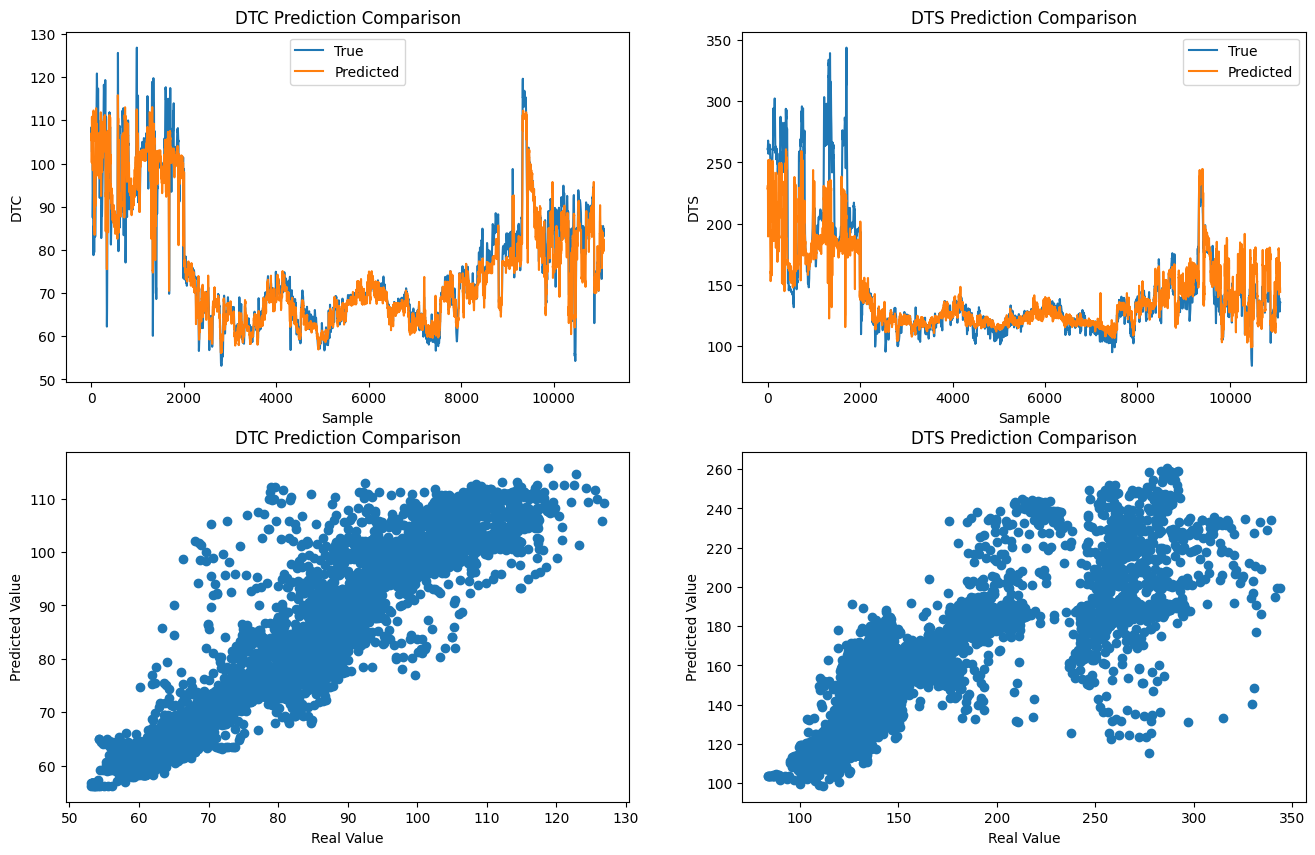

In [44]:
result_plot(preds,reals)

RMSE of test data (#1 DTC): 4.32
RMSE of test data (#2 DTS): 23.11
Overall RMSE = 16.62


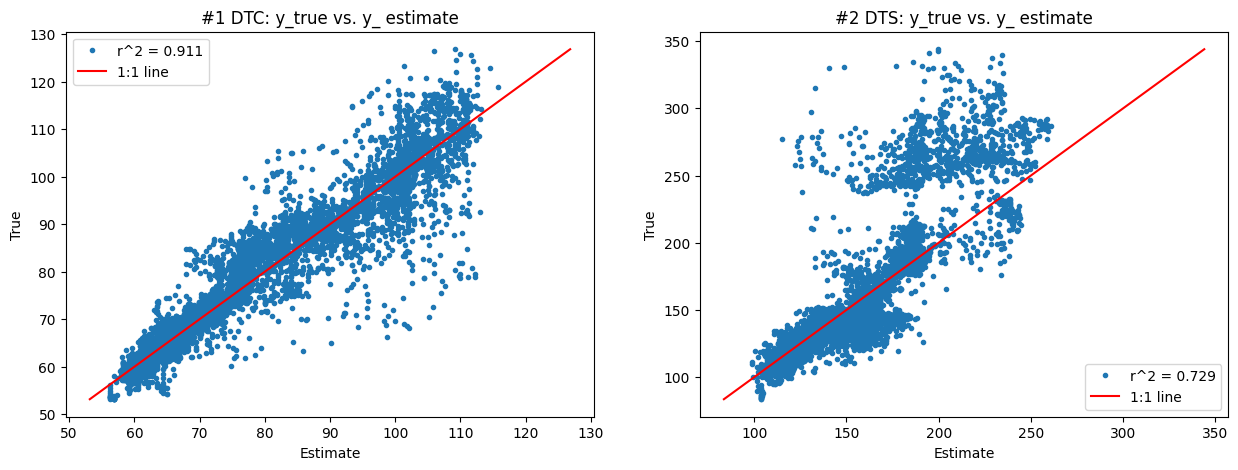

In [45]:
# Plot results:
plt.figure(figsize=(15,5))
i = 0
plt.subplot(1,2,i+1)
plt.plot(preds[:,i], reals[:,i], '.', label = 'r^2 = %.3f' % ((r2_score(reals[:,i], preds[:,i]))))
plt.plot([reals[:,i].min(),reals[:,i].max()],[reals[:,i].min(),reals[:,i].max()], 'r', label = '1:1 line')
plt.title('#1 DTC: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()
i += 1
plt.subplot(1,2,i+1)
plt.plot(preds[:,i], reals[:,i], '.', label = 'r^2 = %.3f' % ((r2_score(reals[:,i], preds[:,i]))))
plt.plot([reals[:,i].min(),reals[:,i].max()],[reals[:,i].min(),reals[:,i].max()], 'r', label = '1:1 line')
plt.title('#2 DTS: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()

MSE_0 = mean_squared_error(reals[:,0], preds[:,0]);
RMSE_0 = np.sqrt(mean_squared_error(reals[:,0], preds[:,0]));
MSE_1 = mean_squared_error(reals[:,1], preds[:,1]);
RMSE_1 = np.sqrt(mean_squared_error(reals[:,1], preds[:,1]));
print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))